<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/Lane_Detection_on_CULane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Papers With Code: CULane](https://paperswithcode.com/sota/lane-detection-on-culane)

[dataset](https://paperswithcode.com/dataset/culane)


https://drive.google.com/drive/folders/1mSLgwVTiaUMAb4AVOWwlCD5JcWdrwpvu


[Kaggle](https://www.kaggle.com/datasets/greatgamedota/culane)

In [ ]:
'اسپرت', 'اسپرت-جورابی', 'اسپرت-راحتی',
        'اسپرت-پوتون', 'تابستانه', 'تابستانه-راحتی', 'تابستانه-راحتی-طبی',
        'تابستانه-مجلسی', 'تابستانه-گوندرا', 'دمپایی', 'دمپایی-تابستانه',
        'راحتی', 'راحتی-طبی', 'راحتی-مجلسی', 'ساقبلند', 'ساقبلند-مجلسی',
        'طبی', 'طبی-راحتی', 'طبی-راحتی-اسپرت', 'مجلسی', 'مجلسی-تابستانه',
        'پوتون', 'پوتون-اسپرت', 'پوتون-راحتی',
        'کالج', 'گوندرا-طبی', 'گوندارا', 'گوندارا-اسپرت',
        'گوندارا-تابستانه', 'گوندارا-راحتی', 'گوندارا-ساقدار',
        'گوندارا-طبی', 'گوندارا-مجلسی', 'گوندارا-کالج'

In [ ]:
import os
import cv2
import PIL
import tqdm
import IPython
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = './drive/MyDrive/'
!kaggle datasets download -d greatgamedota/culane
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

In [ ]:
EPOCHS = 10
NUM_CLASSES = 5
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

# USE ********** sorted ********** NECESSARY
image_files = sorted(tf.io.gfile.glob('./driver_161_90frame/*/*.jpg'))
mask_files = sorted(tf.io.gfile.glob('./driver_161_90frame_labels/*/*.png'))

imagePath_df = pd.DataFrame({'image-path': image_files, 'mask-path': mask_files})
print('The classes of the mask images: ',np.unique(tf.keras.utils.load_img(mask_files[0])))
print(f'So We have {len(np.unique(tf.keras.utils.load_img(mask_files[0])))} CLASSES')
imagePath_df.head()

###What does one input image and corresponding segmentation mask look like?

In [ ]:
N = np.random.randint(0, len(image_files))
IPython.display.display(IPython.display.Image(filename=image_files[N]))

img = PIL.ImageOps.autocontrast(tf.keras.utils.load_img(mask_files[N]))
IPython.display.display(img)

In [ ]:
def data_augmentation(input_data, target_data):
    if tf.random.uniform(()) > 0.5:#brightness
        input_data = tf.image.adjust_brightness(input_data, 0.1)
    if tf.random.uniform(()) > 0.5:#gamma
        input_data = tf.image.adjust_gamma(input_data, 0.1)
    if tf.random.uniform(()) > 0.5:#hue
        input_data = tf.image.adjust_hue(input_data, -0.1)
    return input_data, target_data

In [ ]:
def load_img_masks(input_img_path, target_img_path):
  input_img = tf.io.read_file(input_img_path)
  input_img = tf.io.decode_png(input_img, channels=3)
  input_img = tf.image.resize(input_img, IMAGE_SIZE)
  input_img = tf.image.convert_image_dtype(input_img, "float32")

    # mask_path = tf.strings.regex_replace(img_path, "driver_161_90frame", "driver_161_90frame_labels")
    # mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")

  target_img = tf.io.read_file(target_img_path)
  target_img = tf.io.decode_png(target_img, channels=1)
  target_img = tf.image.resize(target_img, IMAGE_SIZE, method="nearest")
  target_img = tf.image.convert_image_dtype(target_img, "uint8")
  # Ground truth labels if are 1, 2, 3. Subtract one to make them 0, 1, 2:
  # target_img -= 1
  return input_img, target_img

In [ ]:
#SPLIT && SHUFFLE
train_image, val_image, train_mask, val_mask = model_selection.train_test_split(image_files, mask_files, test_size=0.2, random_state=32, shuffle=True)

#TRAIN DATASET
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_mask))
train_dataset = train_dataset.cache()
# train_dataset = train_dataset.shuffle(buffer_size=tf.data.AUTOTUNE, seed=32)
# train_dataset = train_dataset.repeat()
train_dataset = train_dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#VALIDATION DATASET
valid_dataset = tf.data.Dataset.from_tensor_slices((val_image, val_mask))
valid_dataset = valid_dataset.cache()
# valid_dataset = valid_dataset.shuffle(buffer_size=tf.data.AUTOTUNE, seed=32)
# valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.map(load_img_masks, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    prev_block = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(prev_block)

        x = tf.keras.layers.add([x, residual])  # Add back residual
        prev_block = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(prev_block)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        prev_block = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(IMAGE_SIZE, NUM_CLASSES)
model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=valid_dataset,
                    callbacks=callbacks,
                    verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.17649, saving model to model-brain-mri.h5
456/456 - 295s - loss: 0.1804 - accuracy: 0.9668 - val_loss: 0.1765 - val_accuracy: 0.9752 - lr: 1.0000e-04 - 295s/epoch - 646ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.17649 to 0.09483, saving model to model-brain-mri.h5
456/456 - 250s - loss: 0.1036 - accuracy: 0.9736 - val_loss: 0.0948 - val_accuracy: 0.9715 - lr: 1.0000e-04 - 250s/epoch - 549ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.09483 to 0.08532, saving model to model-brain-mri.h5
456/456 - 236s - loss: 0.0920 - accuracy: 0.9740 - val_loss: 0.0853 - val_accuracy: 0.9737 - lr: 1.0000e-04 - 236s/epoch - 518ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.08532 to 0.07954, saving model to model-brain-mri.h5
456/456 - 237s - loss: 0.0849 - accuracy: 0.9744 - val_loss: 0.0795 - val_accuracy: 0.9744 - lr: 1.0000e-04 - 237s/epoch - 519ms/step
Epoch 5/10

Epoch 5: val_loss improved from 0.07954 to 0.07622, saving m

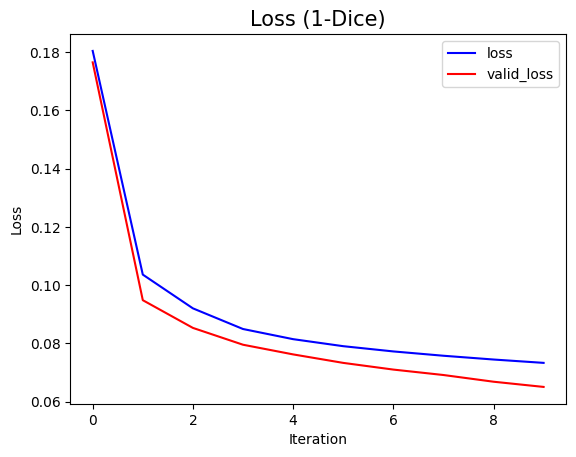

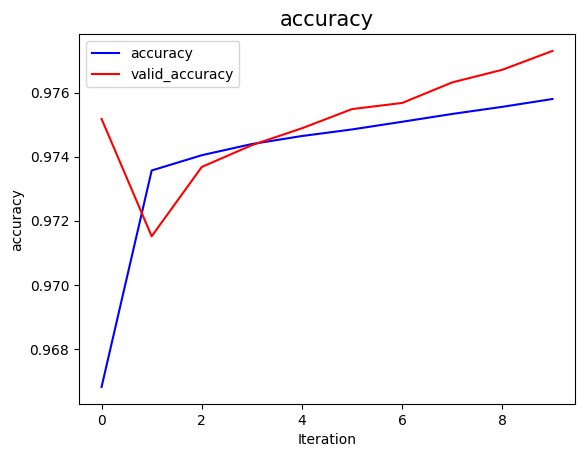

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'],'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='valid_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss (1-Dice)', fontsize = 15)
plt.legend()

plt.figure(2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='valid_accuracy')
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title('accuracy', fontsize = 15)
plt.legend()
plt.show()

### Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set
val_preds = model.predict(valid_dataset)

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    img = np.argmax(val_preds[i], axis=-1)
    H, W = np.array(tf.keras.utils.load_img(val_mask[i])).shape[:-1]
    img = cv2.resize(img, (W, H))
    img = np.expand_dims(img, axis=-1)
    img = tf.keras.utils.array_to_img(img)
    img = PIL.ImageOps.autocontrast(img)
    display(img)


# Display results for validation image #10
i = np.random.randint(len(valid_dataset))

# Display input image
IPython.display.display(IPython.display.Image(filename=val_image[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(tf.keras.utils.load_img(val_mask[i]))
IPython.display.display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

# Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #param {type:"boolean"}
#markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60 #param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#markdown For rapid experimentation, start with a moderate number of examples.
# num_eval_examples = 50  #param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [ ]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [ ]:
train_batches.map(add_sample_weights).element_spec

Now, you can train a model on this weighted dataset:

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)